<a href="https://colab.research.google.com/github/bennop/Kata/blob/master/Med_AI_AD_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook:
1. Anomaly detection for tabular data:
  * 1.1 Load data
  * 1.2 Density estimation AD

2. Anomaly detection for images:
  * Load data
  * Density estimation on raw images
  * AD w. deep representations
  * Add simple metric adaptation

3. Try you own tabular / image dataset!

The slides can be found here:
https://docs.google.com/presentation/d/1GYtnnRaE364T_oTNMBYjdIvCcO8fYsVh/edit?usp=sharing&ouid=113958115966925000213&rtpof=true&sd=true


# Notebook Tips:
## 1. Feel free to ask questions and consult during the the session
## 2. Switch your colab runtim to GPU (Runtime / Change runtime type)
## 3. Note the comments, try to twik different parameters
## 4. To try your own dataset, you might find this useful: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH


# Part 1: **Anomaly detection for tabuler data**

##1.1.1 Download data 
(you can just run the cells with ctrl+shift)

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import torchvision.datasets as dset
import os


In [ ]:
mkdir tabular_data

In [ ]:
cd tabular_data

/content/tabular_data/tabular_data


In [ ]:
#@title Downloading files
%%capture

!wget https://www.dropbox.com/s/632rdwozfnwr7kb/arrhythmia.mat?dl=0
!wget https://www.dropbox.com/s/98ewaxaoq0j0ldf/thyroid.mat?dl=0
!wget https://www.dropbox.com/s/c42lxljv3u1213j/pendigits.mat?dl=0

In [ ]:
ls

'arrhythmia.mat?dl=0'  'pendigits.mat?dl=0'  'thyroid.mat?dl=0'


change the file names of `'arrhythmia.mat?dl=0'  'pendigits.mat?dl=0'  'thyroid.mat?dl=0'` if accordingly


In [ ]:
#@title Data loaders are here


class Data_Loader:

    def __init__(self, n_trains=None):
        self.n_train = n_trains
        self.urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

    def norm_kdd_data(self, train_real, val_real, val_fake, cont_indices):
        symb_indices = np.delete(np.arange(train_real.shape[1]), cont_indices)
        mus = train_real[:, cont_indices].mean(0)
        sds = train_real[:, cont_indices].std(0)
        sds[sds == 0] = 1

        def get_norm(xs, mu, sd):
            bin_cols = xs[:, symb_indices]
            cont_cols = xs[:, cont_indices]
            cont_cols = np.array([(x - mu) / sd for x in cont_cols])
            return np.concatenate([bin_cols, cont_cols], 1)

        train_real = get_norm(train_real, mus, sds)
        val_real = get_norm(val_real, mus, sds)
        val_fake = get_norm(val_fake, mus, sds)
        return train_real, val_real, val_fake


    def norm_data(self, train_real, val_real, val_fake):
        mus = train_real.mean(0)
        sds = train_real.std(0)
        sds[sds == 0] = 1

        def get_norm(xs, mu, sd):
            return np.array([(x - mu) / sd for x in xs])

        train_real = get_norm(train_real, mus, sds)
        val_real = get_norm(val_real, mus, sds)
        val_fake = get_norm(val_fake, mus, sds)
        return train_real, val_real, val_fake

    def norm(self, data, mu=1):
        return 2 * (data / 255.) - mu

    def get_dataset(self, dataset_name, c_percent=None, true_label=1):
        if dataset_name == 'cifar10':
            return self.load_data_CIFAR10(true_label)
        elif dataset_name == 'kdd':
            return self.KDD99_train_valid_data()
        elif dataset_name == 'kddrev':
            return self.KDD99Rev_train_valid_data()
        else:
            return self.General_train_valid_data(dataset_name)
        #if dataset_name == 'thyroid':
        #    return self.Pendigits_train_valid_data()
        #if dataset_name == 'pendigits':
        #    return self.Thyroid_train_valid_data()
        #if dataset_name == 'arrhythmia':
        #    return self.Arrhythmia_train_valid_data()
        if dataset_name == 'ckdd':
            return self.contaminatedKDD99_train_valid_data(c_percent)


    def load_data_CIFAR10(self, true_label):
        root = './data'
        if not os.path.exists(root):
            os.mkdir(root)

        trainset = dset.CIFAR10(root, train=True, download=True)
        train_data = np.array(trainset.data)
        train_labels = np.array(trainset.targets)

        testset = dset.CIFAR10(root, train=False, download=True)
        test_data = np.array(testset.data)
        test_labels = np.array(testset.targets)

        train_data = train_data[np.where(train_labels == true_label)]
        #x_train = self.norm(np.asarray(train_data, dtype='float32'))
        #x_test = self.norm(np.asarray(test_data, dtype='float32'))
        x_train = (np.asarray(train_data, dtype='float32'))
        x_test = (np.asarray(test_data, dtype='float32'))
        return x_train, x_test, test_labels


    def General_train_valid_data(self, str):
        data = scipy.io.loadmat("data/" + str)
        samples = data['X']  # 3772
        labels = ((data['y']).astype(np.int32)).reshape(-1)

        norm_samples = samples[labels == 0]  # 3679 norm
        anom_samples = samples[labels == 1]  # 93 anom

        n_train = len(norm_samples) // 2
        x_train = norm_samples[:n_train]  # 1839 train

        val_real = norm_samples[n_train:]
        val_fake = anom_samples
        return self.norm_data(x_train, val_real, val_fake)

    def Pendigits_train_valid_data(self):
        data = scipy.io.loadmat("pendigits.mat?dl=0")
        samples = data['X']  # 3772
        labels = ((data['y']).astype(np.int32)).reshape(-1)

        norm_samples = samples[labels == 0]  # 3679 norm
        anom_samples = samples[labels == 1]  # 93 anom

        n_train = len(norm_samples) // 2
        x_train = norm_samples[:n_train]  # 1839 train

        val_real = norm_samples[n_train:]
        val_fake = anom_samples
        return self.norm_data(x_train, val_real, val_fake)

    def Thyroid_train_valid_data(self):
        data = scipy.io.loadmat("thyroid.mat?dl=0")
        samples = data['X']  # 3772
        labels = ((data['y']).astype(np.int32)).reshape(-1)

        norm_samples = samples[labels == 0]  # 3679 norm
        anom_samples = samples[labels == 1]  # 93 anom

        n_train = len(norm_samples) // 2
        x_train = norm_samples[:n_train]  # 1839 train

        val_real = norm_samples[n_train:]
        val_fake = anom_samples
        return self.norm_data(x_train, val_real, val_fake)


    def Arrhythmia_train_valid_data(self):
        data = scipy.io.loadmat("arrhythmia.mat?dl=0")
        samples = data['X']  # 518
        labels = ((data['y']).astype(np.int32)).reshape(-1)

        norm_samples = samples[labels == 0]  # 452 norm
        anom_samples = samples[labels == 1]  # 66 anom

        n_train = len(norm_samples) // 2
        x_train = norm_samples[:n_train]  # 226 train

        val_real = norm_samples[n_train:]
        val_fake = anom_samples
        return self.norm_data(x_train, val_real, val_fake)


    def KDD99_preprocessing(self):
        df_colnames = pd.read_csv(self.urls[1], skiprows=1, sep=':', names=['f_names', 'f_types'])
        df_colnames.loc[df_colnames.shape[0]] = ['status', ' symbolic.']
        df = pd.read_csv(self.urls[0], header=None, names=df_colnames['f_names'].values)
        df_symbolic = df_colnames[df_colnames['f_types'].str.contains('symbolic.')]
        df_continuous = df_colnames[df_colnames['f_types'].str.contains('continuous.')]
        samples = pd.get_dummies(df.iloc[:, :-1], columns=df_symbolic['f_names'][:-1])

        smp_keys = samples.keys()
        cont_indices = []
        for cont in df_continuous['f_names']:
            cont_indices.append(smp_keys.get_loc(cont))

        labels = np.where(df['status'] == 'normal.', 1, 0)
        return np.array(samples), np.array(labels), cont_indices


    def KDD99_train_valid_data(self):
        samples, labels, cont_indices = self.KDD99_preprocessing()
        anom_samples = samples[labels == 1]  # norm: 97278

        norm_samples = samples[labels == 0]  # attack: 396743

        n_norm = norm_samples.shape[0]
        ranidx = np.random.permutation(n_norm)
        n_train = n_norm // 2

        x_train = norm_samples[ranidx[:n_train]]
        norm_test = norm_samples[ranidx[n_train:]]

        val_real = norm_test
        val_fake = anom_samples
        return self.norm_kdd_data(x_train, val_real, val_fake, cont_indices)


    def KDD99Rev_train_valid_data(self):
        samples, labels, cont_indices = self.KDD99_preprocessing()

        norm_samples = samples[labels == 1]  # norm: 97278

        # Randomly draw samples labeled as 'attack'
        # so that the ratio btw norm:attack will be 4:1
        # len(anom) = 24,319
        anom_samples = samples[labels == 0]  # attack: 396743

        rp = np.random.permutation(len(anom_samples))
        rp_cut = rp[:24319]
        anom_samples = anom_samples[rp_cut]  # attack:24319

        n_norm = norm_samples.shape[0]
        ranidx = np.random.permutation(n_norm)
        n_train = n_norm // 2

        x_train = norm_samples[ranidx[:n_train]]
        norm_test = norm_samples[ranidx[n_train:]]

        val_real = norm_test
        val_fake = anom_samples
        return self.norm_kdd_data(x_train, val_real, val_fake, cont_indices)


    def contaminatedKDD99_train_valid_data(self, c_percent):
        samples, labels, cont_indices = self.KDD99_preprocessing()

        ranidx = np.random.permutation(len(samples))
        n_test = len(samples)//2
        x_test = samples[ranidx[:n_test]]
        y_test = labels[ranidx[:n_test]]

        x_train = samples[ranidx[n_test:]]
        y_train = labels[ranidx[n_test:]]

        norm_samples = x_train[y_train == 0]  # attack: 396743
        anom_samples = x_train[y_train == 1]  # norm: 97278
        n_contaminated = int((c_percent/100)*len(anom_samples))

        rpc = np.random.permutation(n_contaminated)
        x_train = np.concatenate([norm_samples, anom_samples[rpc]])

        val_real = x_test[y_test == 0]
        val_fake = x_test[y_test == 1]
        return self.norm_kdd_data(x_train, val_real, val_fake, cont_indices)



# **Intresting part starts here**

In [ ]:
dl = Data_Loader()


### Here you can choose a dataset
The description of these dataset can be found here (but you don't have to read it): <br>
https://arxiv.org/pdf/2005.02359.pdf

In [ ]:
dl = Data_Loader()
#train_real, val_real, val_fake = dl.get_dataset("kdd", 0)
#train_real, val_real, val_fake = dl.Thyroid_train_valid_data()
train_real, val_real, val_fake = dl.Arrhythmia_train_valid_data()
#train_real, val_real, val_fake = dl.Pendigits_train_valid_data()
#train_real, val_real, val_fake = dl.contaminatedKDD99_train_valid_data(0.1)

test_label = np.concatenate([np.zeros(len(val_real)), np.ones(len(val_fake))])
test_real = np.concatenate([val_real, val_fake])



In [ ]:
print("train_real",train_real.shape)
print("test_real",test_real.shape)

train_real (193, 274)
test_real (259, 274)


### 1.1.2 Plot features

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)



In [ ]:
test_tsne = tsne.fit_transform(test_real)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 259 samples in 0.000s...
[t-SNE] Computed neighbors for 259 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 259 / 259
[t-SNE] Mean sigma: 6.221649


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.401146
[t-SNE] KL divergence after 300 iterations: 1.144058


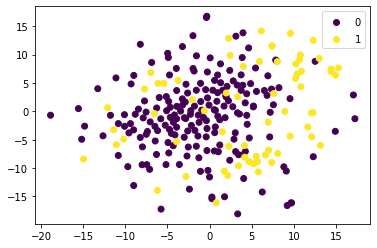

In [ ]:
fig = plt.scatter(test_tsne[:,0], test_tsne[:,1], c=test_label)
plt.legend(*fig.legend_elements())
plt.show()


## 1.2 Anomaly detection by density estimation

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [ ]:
#@title A function to plot the ROC Curve

def plot_scores(test_label, mean_distances):
  # plot the mean distances
  fig = plt.hist(mean_distances[test_label==0], bins=100, alpha=0.5, label='Normal')
  plt.hist(mean_distances[test_label==1], bins=100, alpha=0.5, label='Anomaly')
  plt.legend(loc='upper right')
  plt.xlabel('Anomaly score')
  plt.ylabel('Number of samples')  
  plt.show()

  fpr, tpr, thresholds = roc_curve(test_label, mean_distances)
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()  

  #calc rocauc
  print("roc auc is %.3f"%roc_auc_score(test_label, mean_distances))  

### Simple kNN density estimator
###Try changing `n_neighbors` to control the bias variance tradeoff
https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff

In [ ]:
from sklearn.neighbors import NearestNeighbors

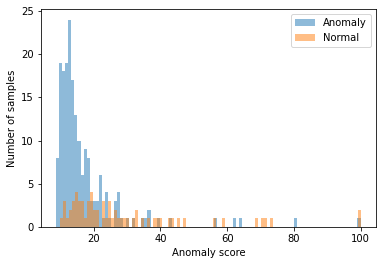

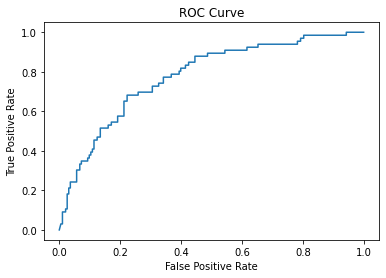

roc auc is 0.778


In [ ]:
# fit on training data
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(train_real)
# get k nearest neighbors of each point in test data
distances, indices = neigh.kneighbors(test_real)
# get the mean distance of each point to its nearest neighbors
mean_distances = np.mean(distances, axis=1)
mean_distances = np.clip(mean_distances, 0, 100)

plot_scores(test_label, mean_distances)

# 2. **Anomaly detection for images**

## 2.1 Load data
### `normal_class` defines the class of CIFAR10 we deem normal

In [ ]:
normal_class = 0

In [ ]:
x_train, x_test, imgage_class = dl.load_data_CIFAR10(true_label = normal_class)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
img_test_label = 1 - (imgage_class == normal_class).astype('int')


In [ ]:
#@title Here you can try to downsample your data

is_short = False
if is_short:
  print("x_train",x_train.shape)
  print("x_test",x_test.shape)
  x_train = x_train[::10]
  x_test = x_test[::10]
  img_test_label = img_test_label[::10]

  print("img_test_label",img_test_label.shape)
  print("x_train",x_train.shape)
  print("x_test",x_test.shape)

###Example of a normal train sample

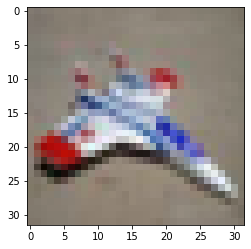

In [ ]:
sample_train = x_train[1]
sample_train = (sample_train - np.min(sample_train)) / (np.max(sample_train) - np.min(sample_train))
plt.imshow(sample_train)

###Example of a test sample
 An `img_test_label` of $1$ ($0$) corresponds to an anomaly (normal sample)

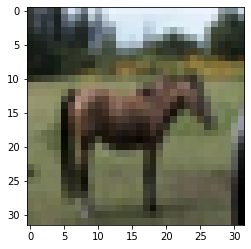

In [ ]:
sample_train = x_test[-1]
sample_train = (sample_train - np.min(sample_train)) / (np.max(sample_train) - np.min(sample_train))
plt.imshow(sample_train)

## 2.2 Density estimation on raw images

In [ ]:
x_train_raw_vector = x_train.reshape((len(x_train), -1))
x_test_raw_vector = x_test.reshape((len(x_test), -1))
print("x_train_raw_vector",x_train_raw_vector.shape)
print("x_test_raw_vector",x_test_raw_vector.shape)

x_train_raw_vector (5000, 3072)
x_test_raw_vector (10000, 3072)


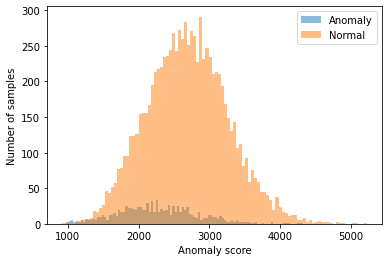

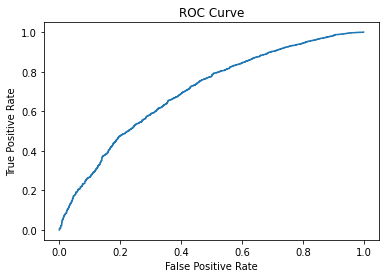

roc auc is 0.701


In [ ]:
# fit on training data
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(x_train_raw_vector)
# get k nearest neighbors of each point in test data
distances, indices = neigh.kneighbors(x_test_raw_vector)
# get the mean distance of each point to its nearest neighbors
mean_distances = np.mean(distances, axis=1)
mean_distances = np.clip(mean_distances, 0, 10000)

plot_scores(img_test_label, mean_distances)

## 2.3 AD w. deep representations


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
net = models.resnet152(pretrained=True)
net = nn.Sequential(*list(net.children())[:-1])

net.eval()
pass

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [ ]:
net.cuda()
batch_size = 64

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])

])

In [ ]:
def get_features(net, set):
    with torch.no_grad():
      features = []
      for i in range(0, len(set), batch_size):
          batch = set[i:i+batch_size]
          #transform batch to tensor using imagenet normalization
          batch = [transform(img) for img in batch]
          batch = torch.stack(batch).cuda()
          batch_features = net(batch).view(batch.size(0), -1).cpu()
          #Normalize features
          batch_features = batch_features / batch_features.norm(dim=1, keepdim=True)
          features.append(batch_features.data.numpy())
      return np.concatenate(features)

In [ ]:
x_train = [Image.fromarray(img.astype(np.uint8)) for img in x_train]
x_test = [Image.fromarray(img.astype(np.uint8)) for img in x_test]

In [ ]:
# This may take a few minutes
train_features = get_features(net, x_train)
test_features = get_features(net, x_test)

In [ ]:
print("train_features",train_features.shape)
print("test_features",test_features.shape)


train_features (5000, 2048)
test_features (10000, 2048)


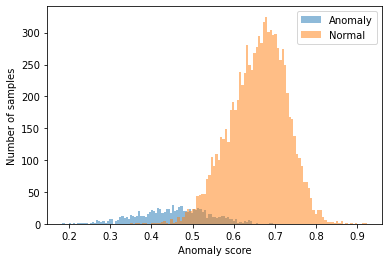

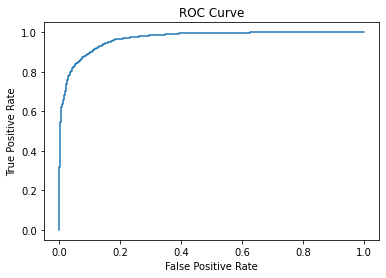

roc auc is 0.968


In [ ]:
# fit on training data
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(train_features)
# get k nearest neighbors of each point in test data
distances, indices = neigh.kneighbors(test_features)
# get the mean distance of each point to its nearest neighbors
mean_distances = np.mean(distances, axis=1)
mean_distances = np.clip(mean_distances, 0, 10000)

plot_scores(img_test_label, mean_distances)

## 2.4 AD with mertic adptation
###2.4.1 Simple Whitening


### Can we do with less data?
### Try changing the `sampling_factor`

In [ ]:
sampling_factor = 1
x_train_raw_vector_short = train_features[::sampling_factor]

In [ ]:
#Whiten that data
from sklearn.decomposition import PCA
pca = PCA(whiten=True)

train_whiten = pca.fit_transform(x_train_raw_vector_short)
test_whiten = pca.transform(test_features)

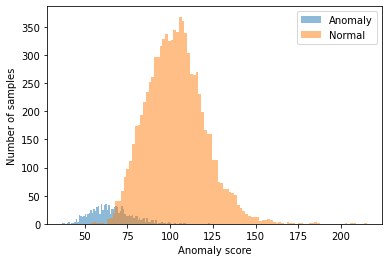

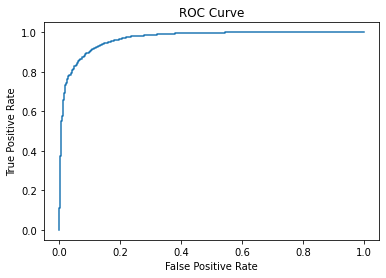

roc auc is 0.968


In [ ]:
# fit on training data
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(train_whiten)
# get k nearest neighbors of each point in test data
distances, indices = neigh.kneighbors(test_whiten)
# get the mean distance of each point to its nearest neighbors
mean_distances = np.mean(distances, axis=1)
mean_distances = np.clip(mean_distances, 0, 10000)

plot_scores(img_test_label, mean_distances)

### What happened?

## 2.4.2 Let's try with shrinkage!
### Try to play with the shrinkage_factor, which tradeoff is it? :-)
### Check out: https://www.youtube.com/watch?app=desktop&v=cUqoHQDinCM&t=594s

In [ ]:
from sklearn.covariance import ShrunkCovariance


class Shrunk_Sphering():
    def __init__(self, shrinkage_factor = 0.1):
        self.shrinkage_factor = shrinkage_factor
        pass

    def fit(self, X):
        print("before cov")
        print("X",X.shape)
        cov = ShrunkCovariance(shrinkage = self.shrinkage_factor).fit(X).covariance_
        print("after cov")
        u, s, vh = np.linalg.svd(cov, hermitian=True, full_matrices=True)
        self.W = np.matmul(np.diag(1/np.sqrt(s)), vh)
        self.mu = X.mean(0)[None, :]

    def transform(self, X):
        X_sph = np.matmul(X - self.mu, self.W.T)
        return X_sph

In [ ]:
shrinkage_factor = 0.1

In [ ]:
zca_sphere = Shrunk_Sphering(shrinkage_factor = shrinkage_factor)
zca_sphere.fit(x_train_raw_vector_short)

train_shrinkage = zca_sphere.transform(x_train_raw_vector_short)
test_shrinkage = zca_sphere.transform(test_features)

before cov
X (5000, 2048)
after cov


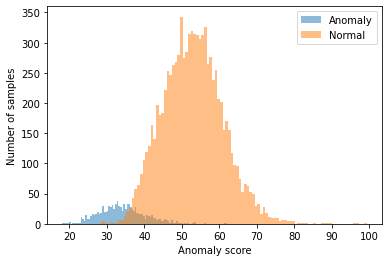

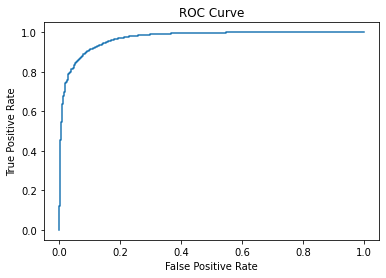

roc auc is 0.970


In [ ]:

# fit on training data
neigh = NearestNeighbors(n_neighbors=2)
neigh.fit(train_shrinkage)
# get k nearest neighbors of each point in test data
distances, indices = neigh.kneighbors(test_shrinkage)
# get the mean distance of each point to its nearest neighbors
mean_distances = np.mean(distances, axis=1)
mean_distances = np.clip(mean_distances, 0, 100)

plot_scores(img_test_label, mean_distances)

## Better adptation methods (not in colab):
https://github.com/talreiss/PANDA <br>
https://github.com/talreiss/Mean-Shifted-Anomaly-Detection

## Anomaly Segmentation Methods: (not in colab):
https://github.com/byungjae89/SPADE-pytorch <br>
https://github.com/amazon-science/patchcore-inspection

# 3. **Try your own dataset!**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from PIL import Image
with Image.open("hopper.jpg") as im:
    im.rotate(45).show()